## Hecht-Mendez 3D Borehole Heat Exchanger Problem

The purpose of this script is to (1) recreate the 3D heat transport example
first published in Groundwater in 2010 titled, "Evaluating MT3DMS for Heat
Transport Simulation of Closed Geothermal Systems," and (2) compare MF6-GWT
solutions to the published MT3DMS solution.

Note: The original problem employed the FHB boundary package to specify
      heads on the left and right boundaries.  For this script, the same
      boundary conditions are achieved using the specified head option
      within the .bas package (specifies -1 for ibound which locks in the
      starting heads and constant heads)

Within the script that generates and runs the model, a user seeking to
compare MODFLOW results with MT3D-USGS may do so by setting the parameter
runMT3D equal to True on (or near). The correct line of script to adjust
will look similar to scenario(1, runMT3D=False, silent=False).

For the first simulated scenario with a Peclet value of 1.0, simulated fits
to the analytical solution can be improved by refining the temporal
resolution of the simulation.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import git
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles
from modflow_devtools.misc import get_env, timed
from scipy.special import erf, erfc

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
name = "hecht-mendez"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
data_path = root / "data" / name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "seconds"

# Set scenario parameters (make sure there is at least one blank line before next item)
# This entire dictionary is passed to _build_models()_ using the kwargs argument
parameters = {
    "ex-gwt-hecht-mendez-a": {
        "peclet": 0.0,
        "gradient": 0.0,
        "seepagevelocity": 0.0,
        "constantheadright": 14,
    },
    "ex-gwt-hecht-mendez-b": {
        "peclet": 1.0,
        "gradient": 1.2e-4,
        "seepagevelocity": 3.7e-6,
        "constantheadright": 13.964,
    },
    "ex-gwt-hecht-mendez-c": {
        "peclet": 10.0,
        "gradient": 1.2e-3,
        "seepagevelocity": 3.7e-5,
        "constantheadright": 13.64,
    },
}

# Scenario parameter units
# add parameter_units to add units to the scenario parameter table that is automatically
# built and used by the .tex input
parameter_units = {
    "peclet": "$unitless$",
    "gradient": "$m/m$",
    "seepagevelocity": "$m/s$",
    "constantheadright": "$m$",
}

# Model parameters
nlay = 13  # Number of layers
nrow = 83  # Number of rows
ncol = 247  # Number of columns
delr = "varies"  # Column width ($m$)
delc = "varies"  # Row width ($m$)
width = 200  # Simulation width ($m$)
length = 300  # Simulation length ($m$)
delz = 1.0  # Layer thickness ($m$)
top = 13.0  # Top of the model ($m$)
satthk = 13.0  # Saturated thickness ($m$)
hk = 8.0e-3  # Horizontal hydraulic conductivity($m/s$)
vk = 8.0e-3  # Vertical hydraulic conductivity($m/s$)
T0 = 285.15  # Initial temperature of aquifer ($K$)
prsity = 0.26  # Porosity
al = 0.50  # Longitudinal dispersivity ($m$)
trpt = 0.1  # Ratio of horizontal transverse dispersivity to longitudinal dispersivity
trpv = 0.1  # Ratio of vertical transverse dispersivity to longitudinal dispersivity
rhob = 1961.0  # Aquifer bulk density ($kg/m^3$)
sp1 = 2.103e-4  # Distribution coefficient ($m^3/kg$)
perlen = 12960000.0  # Simulation time ($seconds$) (=~150 days)

# Additional model input
delr = (
    3 * [10.0]
    + 2 * [8.0]
    + 2 * [4.0]
    + 2 * [2.0]
    + 4 * [1.0]
    + 8 * [0.5]
    + 1 * [0.1]
    + 200 * [0.5]
    + 10 * [1.0]
    + 2 * [2.0]
    + 2 * [4.0]
    + 2 * [8.0]
    + 8 * [10.0]
    + 1 * [15.9]
)
delc = (
    6 * [10.0]
    + 1 * [8.0]
    + 2 * [4.0]
    + 2 * [2.0]
    + 10 * [1.0]
    + 20 * [0.5]
    + 1 * [0.1]
    + 20 * [0.5]
    + 10 * [1.0]
    + 2 * [2.0]
    + 2 * [4.0]
    + 1 * [8.0]
    + 6 * [10.0]
)
botm = [top - delz * k for k in range(1, nlay + 1)]
laytyp = icelltype = 0
# Starting Heads:
strt = np.ones((nlay, nrow, ncol), dtype=float) * 14.0

# Active model domain
ibound = np.ones((nlay, nrow, ncol), dtype=int)
ibound[:, :, 0] = -1  # left side
ibound[:, :, -1] = -1  # right side

idomain = 1

# Transport related
icbund = np.ones((nlay, nrow, ncol))
icbund[:, :, 0] = -1
# Starting concentrations:
sconc = T0
# Dispersion
ath1 = al * trpt
atv = al * trpv
dmcoef_arr = 1.84e-6  # m^2/s
# From the Hecht-Mendez manuscript:
# "The 3D analytical solutions A4 and A5 consider a semi-infinite medium and
# therefore they neglect upgradient spreading.  Accordingly, for consistency,
# thermal conductivity and dispersivity are set to zero in the area upgradient
# from the source in MT3DMS"
# dmcoef_arr = np.ones((nlay, nrow, ncol)) * 1.84e-6  # m^2/s
# dmcoef_arr[:, 0:82, 0:21] = 0.0

# Time variables
nstp = 1
transport_stp_len = 60000  # seconds simulated per transport step (16.66 hr)
ttsmult = 1.0

# Advection
mixelm = -1
percel = 1.0

# Boundary condition (BHE: "Borehole Heat Exchanger")
# Note: The manuscript is a bit different than the actual model input file. In
#       the manuscript, it states, "The BHE for the 3D scenarios is
#       represented as [a] point source by three cells within the three middle
#       layers (sixth, seventh, and eighth layers)."  However, the model input
#       file that was obtained from Hecht-Mendez only included the 7th layer.
#       So, for now, the script will mimic the original MT3DMS input and omit
#       layers 6 and 8 as stated in the text.
ssm_bhe = [[7 - 1, 42 - 1, 22 - 1, -1.434e-5, 15]]
mf6_bhe = [[(7 - 1, 42 - 1, 22 - 1), -1.434e-5]]

# Reactive transport related terms
isothm = 1  # sorption type; 1=linear isotherm (equilibrium controlled)
sp2 = 2.0  # w/ isothm = 1 this is read but not used
rhob = 1.7  # g/cm^3
sp1 = 0.176  # cm^3/g  (Kd: "Distribution coefficient")

# Transport observations
cobs = [(7 - 1, 42 - 1, k - 1) for k in range(22, 224, 2)]

# Solver settings
nouter, ninner = 100, 300
hclose, rclose, relax = 5e-5, 1e-8, 1.0

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def hechtMendez_SS_3d(
    x_pos, To, Y3d, Z3d, ath, atv, Fplanar, va, n, rhow, cw, thermdiff
):
    """
    Calculate the analytical solution for changes in temperature three-
    dimensional changes in temperature using transient solution provided in
    the appendix of Hecht-Mendez et al. (2010) as equation A5.  Note that for
    SS conditions, the erfc term reduces to 1 as t -> infinity and the To/2
    term becomes T.

    Parameters
    ----------
    x_pos : float or ndarray
        x position
    To : float or ndarray
         initial temperature of the ground, degrees K
    Y3d : float or ndarray
          dimension of source in y direction for 3D test problem
    Z3d : float or ndarray
          dimension of source in z direction for 3D test problem
    ath : float or ndarray
          transverse horizontal dispersivity
    atv : float or ndarray
          transverse vertical dispersivity
    Fplanar : float or ndarray
              energy extraction (point source)
    va : float or ndarray
         seepage velocity
    n : float or ndarray
        porosity
    rhow : float or ndarray
           desity of water
    cw : float or ndarray
         specific heat capacity of water
    thermdiff : float or ndarray
                molecular diffusion coefficient, or in this case thermal
                diffusivity
    """

    # calculate transverse horizontal heat dispersion
    Dy = ath * (va**2 / abs(va)) + thermdiff
    t2 = erf(Y3d / (4 * np.sqrt(Dy * (x_pos / va))))

    Dz = atv * (va**2 / abs(va)) + thermdiff
    t3 = erf(Z3d / (4 * np.sqrt(Dz * (x_pos / va))))

    # initial temperature at the source
    To_planar = Fplanar / (abs(va) * n * rhow * cw)

    sln = To + (To_planar * t2 * t3)
    return sln


def hechtMendezSS(x_pos, y, a, F0, va, n, rhow, cw, thermdiff):
    """
    Calculate the analytical solution for changes in temperature three-
    dimensional changes in temperature for a steady state solution provided in
    the appendix of Hecht-Mendez et al. (2010) as equation A4

    Parameters
    ----------
    x : float or ndarray
        x position
    y : float or ndarray
        y position
    a : float or ndarray
        longitudinal dispersivity
    F0 : float or ndarray
         energy extraction (point source)
    va : float or ndarray
         seepage velocity
    n : float or ndarray
        porosity
    rhow : float or ndarray
           desity of water
    cw : float or ndarray
         specific heat capacity of water
    thermdiff : float or ndarray
                molecular diffusion coefficient, or in this case thermal
                diffusivity
    """

    # calculate transverse horizontal heat dispersion
    Dth = a * (va**2 / abs(va)) + thermdiff

    t1 = F0 / (va * n * rhow * cw * ((4 * np.pi * Dth * (x_pos / va)) ** (0.5)))
    t2 = np.exp((-1 * va * y**2) / (4 * Dth * x_pos))
    sln = t1 * t2
    return sln


def hechtMendez3d(x_pos, t, Y, Z, al, ath, atv, thermdiff, va, n, R, Fplanar, cw, rhow):
    """
    Calculate the analytical solution for three-dimensional changes in
    temperature based on the solution provided in the appendix of Hecht-Mendez
    et al. (2010) as equation A5

    Parameters
    ----------
    x : float or ndarray
        x position
    t : float or ndarray
        time
    Y : float or ndarray
        dimension of the source in the y direction
    Z : float or ndarray
        dimension of the source in the z direction
    al : float or ndarray
         longitudinal dispersivity
    ath : float or ndarray
          transverse horizontal dispersivity
    atv : float or ndarray
          transverse vertical dispersivity
    thermdiff : float or ndarray
                molecular diffusion coefficient, or in this case thermal
                diffusivity
    va : float or ndarray
         seepage velocity
    n : float or ndarray
        porosity
    R : float or ndarray
        retardation coefficient
    Fplanar : float or ndarray
              energy extraction (point source)
    cw : float or ndarray
         specific heat capacity of water
    rhow : float or ndarray
           desity of water

    """
    To_planar = Fplanar / (va * n * rhow * cw)

    Dl = al * (va**2 / abs(va)) + thermdiff
    numer = R * x_pos - va * t
    denom = 2 * np.sqrt(Dl * R * t)

    t1 = (To_planar / 2) * erfc(numer / denom)

    Dth = ath * (va**2 / abs(va)) + thermdiff
    t2 = erf(Y / (4 * np.sqrt(Dth * (x_pos / va))))

    Dtv = atv * (va**2 / abs(va)) + thermdiff
    t3 = erf(Z / (4 * np.sqrt(Dtv * (x_pos / va))))

    sln = t1 * t2 * t3
    return sln


def build_mf2k5_flow_model(
    sim_name,
    peclet=0.0,
    gradient=0,
    seepagevelocity=0,
    constantheadright=14,
    silent=False,
):
    print(f"Building mf2005 model...{sim_name}")
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    modelname_mf = "hecht-mendez"

    # Instantiate the MODFLOW model
    mf = flopy.modflow.Modflow(
        modelname=modelname_mf, model_ws=mt3d_ws, exe_name="mf2005"
    )

    # Instantiate discretization package
    # units: itmuni=4 (days), lenuni=2 (m)
    flopy.modflow.ModflowDis(
        mf,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        perlen=perlen,
        nstp=nstp,
        itmuni=4,
        lenuni=1,
        steady=True,
    )

    # Instantiate basic package
    strt[:, :, -1] = constantheadright
    flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

    # Instantiate layer property flow package
    flopy.modflow.ModflowLpf(mf, hk=hk, layvka=0, vka=vk, laytyp=laytyp)

    # Instantiate solver package
    flopy.modflow.ModflowPcg(
        mf,
        mxiter=90,
        iter1=20,
        npcond=1,
        hclose=hclose,
        rclose=rclose,
        relax=relax,
        nbpol=2,
        iprpcg=2,
        mutpcg=0.0,
    )

    # Instantiate link mass transport package (for writing linker file)
    flopy.modflow.ModflowLmt(mf)

    # Instantiate output control (OC) package
    spd = {
        (0, 0): ["save head"],
    }
    oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd)

    return mf


def build_mf6_flow_model(
    sim_name,
    peclet=0.0,
    gradient=0,
    seepagevelocity=0,
    constantheadright=14,
    silent=False,
):
    print(f"Building mf6gwf model...{sim_name}")
    gwfname = "gwf-" + name
    sim_ws = os.path.join(workspace, sim_name, "mf6gwf")
    sim = flopy.mf6.MFSimulation(sim_name=gwfname, sim_ws=sim_ws, exe_name="mf6")

    # Instantiating MODFLOW 6 time discretization
    tdis_rc = []
    tdis_rc.append((perlen, 1, 1.0))
    flopy.mf6.ModflowTdis(sim, nper=1, perioddata=tdis_rc, time_units=time_units)

    # Instantiating MODFLOW 6 groundwater flow model
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=gwfname,
        save_flows=True,
        model_nam_file=f"{gwfname}.nam",
    )

    # Instantiating MODFLOW 6 solver for flow model
    imsgwf = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="CG",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwfname}.ims",
    )
    sim.register_ims_package(imsgwf, [gwf.name])

    # Instantiating MODFLOW 6 discretization package
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwfname}.dis",
    )

    # Instantiating MODFLOW 6 initial conditions package for flow model
    strt[:, :, -1] = constantheadright
    flopy.mf6.ModflowGwfic(gwf, strt=strt, filename=f"{gwfname}.ic")

    # Instantiating MODFLOW 6 node-property flow package
    flopy.mf6.ModflowGwfnpf(
        gwf,
        save_flows=True,
        k33overk=False,
        icelltype=laytyp,
        k=hk,
        k33=vk,
        save_specific_discharge=True,
        save_saturation=True,
        filename=f"{gwfname}.npf",
    )

    # Instantiate storage package
    flopy.mf6.ModflowGwfsto(gwf, ss=0, sy=0, filename=f"{gwfname}.sto")

    # Instantiating MODFLOW 6 constant head package
    # MF6 constant head boundaries:
    chdspd = []
    # Loop through the left & right sides for all layers.
    for k in range(nlay):
        for i in range(nrow):
            # left-most column:
            #              (l, r,      c),               head, conc
            chdspd.append([(k, i, 0), strt[k, i, 0], T0])  # left
            # right-most column:
            chdspd.append([(k, i, ncol - 1), strt[k, i, ncol - 1], T0])

    chdspd = {0: chdspd}

    flopy.mf6.ModflowGwfchd(
        gwf,
        maxbound=len(chdspd),
        stress_period_data=chdspd,
        save_flows=False,
        auxiliary="CONCENTRATION",
        pname="CHD-1",
        filename=f"{gwfname}.chd",
    )

    # Instantiating MODFLOW 6 output control package for flow model
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=f"{gwfname}.hds",
        budget_filerecord=f"{gwfname}.bud",
        headprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("HEAD", "LAST"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[
            ("HEAD", "LAST"),
            ("BUDGET", "LAST"),
        ],
    )
    return sim


def build_mt3d_transport_model(
    mf,
    sim_name,
    peclet=0.0,
    gradient=0,
    seepagevelocity=0,
    constantheadright=14,
    silent=False,
):
    # Transport
    print(f"Building mt3dms model...{sim_name}")

    modelname_mt = "hecht-mendez_mt"
    mt3d_ws = os.path.join(workspace, sim_name, "mt3d")
    mt = flopy.mt3d.Mt3dms(
        modelname=modelname_mt,
        model_ws=mt3d_ws,
        exe_name="mt3dms",
        modflowmodel=mf,
    )

    # Instantiate basic transport package
    if seepagevelocity == 0:
        dt0 = 50000
    else:
        dt0 = 0.0

    flopy.mt3d.Mt3dBtn(
        mt,
        icbund=icbund,
        prsity=prsity,
        sconc=sconc,
        cinact=-1e10,
        thkmin=0.01,
        ifmtcn=-2,
        nprs=2,
        timprs=[864000, 12960000],  # 10, 150 days
        dt0=dt0,
        obs=cobs,
        chkmas=False,
        perlen=perlen,
        nstp=nstp,
        tsmult=ttsmult,
        mxstrn=20000,
    )

    # Instatiate the advection package
    flopy.mt3d.Mt3dAdv(mt, mixelm=mixelm, percel=percel)

    # Instantiate the dispersion package
    flopy.mt3d.Mt3dDsp(
        mt, multiDiff=True, al=al, trpt=trpt, trpv=trpv, dmcoef=dmcoef_arr
    )

    # Instantiate the source/sink mixing package
    ssmspd = {0: ssm_bhe}
    flopy.mt3d.Mt3dSsm(
        mt, mxss=nrow * ncol * 2 + len(ssm_bhe), stress_period_data=ssmspd
    )

    # Instantiate the reaction package
    flopy.mt3d.Mt3dRct(mt, isothm=isothm, igetsc=0, rhob=rhob, sp1=sp1, sp2=sp2)

    # Instantiate the GCG solver in MT3DMS
    flopy.mt3d.Mt3dGcg(mt, mxiter=100, iter1=50, isolve=1, ncrs=1, cclose=1e-7)


def build_mf6_transport_model(
    sim_name,
    peclet=0.0,
    gradient=0,
    seepagevelocity=0,
    constantheadright=14,
    silent=False,
):
    # Instantiating MODFLOW 6 groundwater transport package
    print(f"Building mf6gwt model...{sim_name}")
    gwtname = "gwt-" + name
    sim_ws = os.path.join(workspace, sim_name, "mf6gwt")
    sim = flopy.mf6.MFSimulation(sim_name=gwtname, sim_ws=sim_ws, exe_name="mf6")

    # MF6 time discretization is a bit different than corresponding flow simulation
    tdis_rc = None
    if peclet == 1.0:
        # use tsmult to and hardwired number of steps to make it run fast
        tdis_rc = [(perlen, 25, 1.3)]
    elif peclet == 10.0:
        transport_stp_len = 1.296e5 * 3
        nstp_transport = perlen / transport_stp_len
        tdis_rc = [(perlen, nstp_transport, 1.0)]
    flopy.mf6.ModflowTdis(
        sim, nper=len(tdis_rc), perioddata=tdis_rc, time_units=time_units
    )

    gwtname = "gwt-" + name
    gwt = flopy.mf6.MFModel(
        sim,
        model_type="gwt6",
        modelname=gwtname,
        model_nam_file=f"{gwtname}.nam",
    )
    gwt.name_file.save_flows = True

    # create iterative model solution and register the gwt model with it
    imsgwt = flopy.mf6.ModflowIms(
        sim,
        print_option="SUMMARY",
        outer_dvclose=hclose,
        outer_maximum=nouter,
        under_relaxation="NONE",
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=rclose,
        linear_acceleration="BICGSTAB",
        scaling_method="NONE",
        reordering_method="NONE",
        relaxation_factor=relax,
        filename=f"{gwtname}.ims",
    )
    sim.register_ims_package(imsgwt, [gwt.name])

    # Instantiating MODFLOW 6 transport discretization package
    flopy.mf6.ModflowGwtdis(
        gwt,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
        idomain=idomain,
        filename=f"{gwtname}.dis",
    )

    # Instantiating MODFLOW 6 transport initial concentrations
    flopy.mf6.ModflowGwtic(gwt, strt=sconc, filename=f"{gwtname}.ic")

    # Instantiating MODFLOW 6 transport advection package
    if mixelm >= 0:
        scheme = "UPSTREAM"
    elif mixelm == -1:
        scheme = "TVD"
    else:
        raise Exception()
    flopy.mf6.ModflowGwtadv(gwt, scheme=scheme, filename=f"{gwtname}.adv")

    # Instantiating MODFLOW 6 transport dispersion package
    if al != 0:
        flopy.mf6.ModflowGwtdsp(
            gwt,
            alh=al,
            ath1=ath1,
            atv=atv,
            diffc=dmcoef_arr,
            pname="DSP-1",
            filename=f"{gwtname}.dsp",
        )

    # Instantiating MODFLOW 6 transport mass storage package
    Kd = sp1
    flopy.mf6.ModflowGwtmst(
        gwt,
        porosity=prsity,
        first_order_decay=False,
        decay=None,
        decay_sorbed=None,
        sorption="linear",
        bulk_density=rhob,
        distcoef=Kd,
        pname="MST-1",
        filename=f"{gwtname}.mst",
    )

    # Instantiating MODFLOW 6 transport source-sink mixing package
    sourcerecarray = [("CHD-1", "AUX", "CONCENTRATION")]
    flopy.mf6.ModflowGwtssm(
        gwt,
        sources=sourcerecarray,
        print_flows=True,
        filename=f"{gwtname}.ssm",
    )

    flopy.mf6.ModflowGwtsrc(
        gwt,
        print_flows=True,
        maxbound=len(mf6_bhe),
        stress_period_data={0: mf6_bhe},
        pname="SRC-1",
        filename=f"{gwtname}.src",
    )

    # Instantiating MODFLOW 6 Flow-Model Interface package
    flow_name = gwtname.replace("gwt", "gwf")
    pd = [
        ("GWFHEAD", "../mf6gwf/" + flow_name + ".hds", None),
        ("GWFBUDGET", "../mf6gwf/" + flow_name + ".bud", None),
    ]
    flopy.mf6.ModflowGwtfmi(gwt, packagedata=pd)

    # Instantiating MODFLOW 6 transport output control package
    flopy.mf6.ModflowGwtoc(
        gwt,
        budget_filerecord=f"{gwtname}.cbc",
        concentration_filerecord=f"{gwtname}.ucn",
        concentrationprintrecord=[("COLUMNS", 10, "WIDTH", 15, "DIGITS", 6, "GENERAL")],
        saverecord=[
            ("CONCENTRATION", "LAST"),
            ("CONCENTRATION", "STEPS", "15"),
            ("BUDGET", "LAST"),
        ],
        printrecord=[("CONCENTRATION", "LAST"), ("BUDGET", "LAST")],
        filename=f"{gwtname}.oc",
    )

    return sim


def write_mf2k5_models(mf2k5, mt3d, silent=True):
    mf2k5.write_input()
    mt3d.write_input()


def write_mf6_models(sim_mf6gwf, sim_mf6gwt, silent=True):
    sim_mf6gwf.write_simulation(silent=silent)
    sim_mf6gwt.write_simulation(silent=silent)


@timed
def run_models(sim_mf6gwf, sim_mf6gwt, mf2k5=None, mt3d=None, silent=True):
    if mf2k5 is not None:
        success, buff = mf2k5.run_model(silent=silent)

    if mt3d is not None:
        success, buff = mt3d.run_model(silent=silent)

    success, buff = sim_mf6gwf.run_simulation(silent=silent)
    success, buff = sim_mf6gwt.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
figure_size = (5.5, 2.75)


def plot_results(
    sim_mf6gwf,
    sim_mf6gwt,
    idx,
    mf2k5=None,
    mt3d=None,
    ax=None,
    peclet=0.0,
    gradient=0,
    seepagevelocity=0,
    constantheadright=14,
):
    if mt3d is not None:
        mt3d_out_path = mt3d.model_ws

        # Get the MT3DMS concentration output
        fname_mt3d = os.path.join(mt3d_out_path, "MT3D001.UCN")
        ucnobj_mt3d = flopy.utils.UcnFile(fname_mt3d)
        times_mt3d = ucnobj_mt3d.get_times()
        conc_mt3d = ucnobj_mt3d.get_alldata()

    mf6_out_path = sim_mf6gwt.simulation_data.mfpath.get_sim_path()

    # Get the MF6 concentration output
    gwt = sim_mf6gwt.get_model("gwt-" + name)
    ucnobj_mf6 = gwt.output.concentration()

    times_mf6 = ucnobj_mf6.get_times()
    conc_mf6 = ucnobj_mf6.get_alldata()

    # Get the x location of the cell centroids
    model_centroids_x = []
    for i, (cum_pos, half_width) in enumerate(zip(np.cumsum(delr), np.divide(delr, 2))):
        if i > 0:
            model_centroids_x.append(cum_pos - half_width)
        else:
            model_centroids_x.append(half_width)

    # Next subtract off the location of the BHE
    model_centroids_x_BHE = [val - model_centroids_x[21] for val in model_centroids_x]
    # Drop the negative locations to the left of the BHE
    model_centroids_x_right_of_BHE = model_centroids_x_BHE[22:]  # Does not include

    # Analytical solution(s)
    To = T0  # deg K (initial temperature of the ground)
    Y3d = 0.1  # m
    Z3d = delz  # m
    ath = al * trpt  # m
    atv = al * trpv  # m
    F0 = -60  # W/m
    Fplanar = -600  # W/m^2
    va = seepagevelocity
    n = prsity  # porosity
    rhow = 1000.0  # density of water
    cw = 4185.0  # heat capacity of water
    thermdiff = 1.86e-6  # "molecular diffusion" representing heat
    # conduction

    x_pos = np.array(model_centroids_x_right_of_BHE)
    ss_sln = hechtMendez_SS_3d(
        x_pos, To, Y3d, Z3d, ath, atv, Fplanar, va, n, rhow, cw, thermdiff
    )

    t = 864000  # seconds (10 days)
    Y = 0.1  # dimension of source in the y direction
    Z = delz  # dimension of source in the z direction
    R = 2.59  # From Hecht-Mendez manuscript

    tr_sln = hechtMendez3d(
        x_pos,
        t,
        Y,
        Z,
        al,
        ath,
        atv,
        thermdiff,
        va,
        n,
        R,
        Fplanar,
        cw,
        rhow,
    )

    # list of where to draw vertical lines
    avlines = list(range(10)) + list(range(10, 110, 10))

    # fill variables with analytical solutions
    y_ss_anly_sln = ss_sln
    y_tr_anly_sln = [285.15 + val for val in tr_sln]

    # fill variables containing the simulated solutions
    if mt3d is not None:
        y_10_mt_sln = conc_mt3d[0, 6, (42 - 1), 22:]
        y_150_mt_sln = conc_mt3d[-1, 6, (42 - 1), 22:]

    y_10_mf6_sln = conc_mf6[0, 6, (42 - 1), 22:]
    y_150_mf6_sln = conc_mf6[-1, 6, (42 - 1), 22:]

    # Create figure for scenario
    with styles.USGSPlot() as fs:
        sim_name = sim_mf6gwt.name
        plt.rcParams["lines.dashed_pattern"] = [5.0, 5.0]

        if ax is None:
            fig = plt.figure(figsize=figure_size, dpi=300, tight_layout=True)
            ax = fig.add_subplot(1, 1, 1)

        for xc in avlines:
            ax.axvline(x=xc, color="k", linestyle=":", alpha=0.1)

        ss_ln = ax.plot(
            x_pos,
            y_ss_anly_sln,
            "r-",
            label="Steady state analytical solution",
        )
        tr_ln = ax.plot(
            x_pos, y_tr_anly_sln, "b-", label="Transient analytical solution"
        )

        if mt3d is not None:
            mt_ss_ln = ax.plot(
                x_pos, y_150_mt_sln, "r+", label="Steady state MT3DMS, TVD"
            )
            mt_tr_ln = ax.plot(x_pos, y_10_mt_sln, "b+", label="Transient MT3DMS")

        mf6_ss_ln = ax.plot(x_pos, y_150_mf6_sln, "rx", label="Steady-state MF6-GWT")
        mf6_tr_ln = ax.plot(
            x_pos,
            y_10_mf6_sln,
            "bo",
            markerfacecolor="none",
            label="Transient MF6-GWT",
        )
        ax.set_xlim(1, 100)
        ax.set_ylim(285.15 - 2.1, 285.15 + 0.5)
        ax.set_xscale("log")
        ax.set_xlabel("x-coordinate, in meters")
        ax.set_ylabel("temperature, in Kelvins")
        ax.legend()
        plt.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            letter = chr(ord("@") + idx + 1)
            fpth = figs_path / "{}{}".format(
                "ex-" + sim_name + "-" + letter,
                ".png",
            )
            fig.savefig(fpth)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

Building mf6gwf model...ex-gwt-hecht-mendez-b
Building mf6gwt model...ex-gwt-hecht-mendez-b
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf-hecht-mendez...
    writing model name file...
    writing package dis...
    writing package ic...


    writing package npf...
    writing package sto...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2158 based on size of stress_period_data
    writing package oc...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwt-hecht-mendez...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp-1...
    writing package mst-1...
    writing package ssm...
    writing package src-1...
    writing package fmi...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compil

    Solving:  Stress period:     1    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/14 20:10:14
 Elapsed run time:  3.069 Seconds
 
 Normal termination of simulation.
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 13 2024 02:36:38 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
s

    Solving:  Stress period:     1    Time step:     1


    Solving:  Stress period:     1    Time step:     2


    Solving:  Stress period:     1    Time step:     3


    Solving:  Stress period:     1    Time step:     4


    Solving:  Stress period:     1    Time step:     5


    Solving:  Stress period:     1    Time step:     6


    Solving:  Stress period:     1    Time step:     7


    Solving:  Stress period:     1    Time step:     8


    Solving:  Stress period:     1    Time step:     9


    Solving:  Stress period:     1    Time step:    10


    Solving:  Stress period:     1    Time step:    11


    Solving:  Stress period:     1    Time step:    12


    Solving:  Stress period:     1    Time step:    13


    Solving:  Stress period:     1    Time step:    14


    Solving:  Stress period:     1    Time step:    15


    Solving:  Stress period:     1    Time step:    16


    Solving:  Stress period:     1    Time step:    17


    Solving:  Stress period:     1    Time step:    18


    Solving:  Stress period:     1    Time step:    19


    Solving:  Stress period:     1    Time step:    20


    Solving:  Stress period:     1    Time step:    21


    Solving:  Stress period:     1    Time step:    22


    Solving:  Stress period:     1    Time step:    23


    Solving:  Stress period:     1    Time step:    24


    Solving:  Stress period:     1    Time step:    25


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/14 20:11:06
 Elapsed run time: 51.887 Seconds
 
 Normal termination of simulation.
run_models took 54988.41 ms


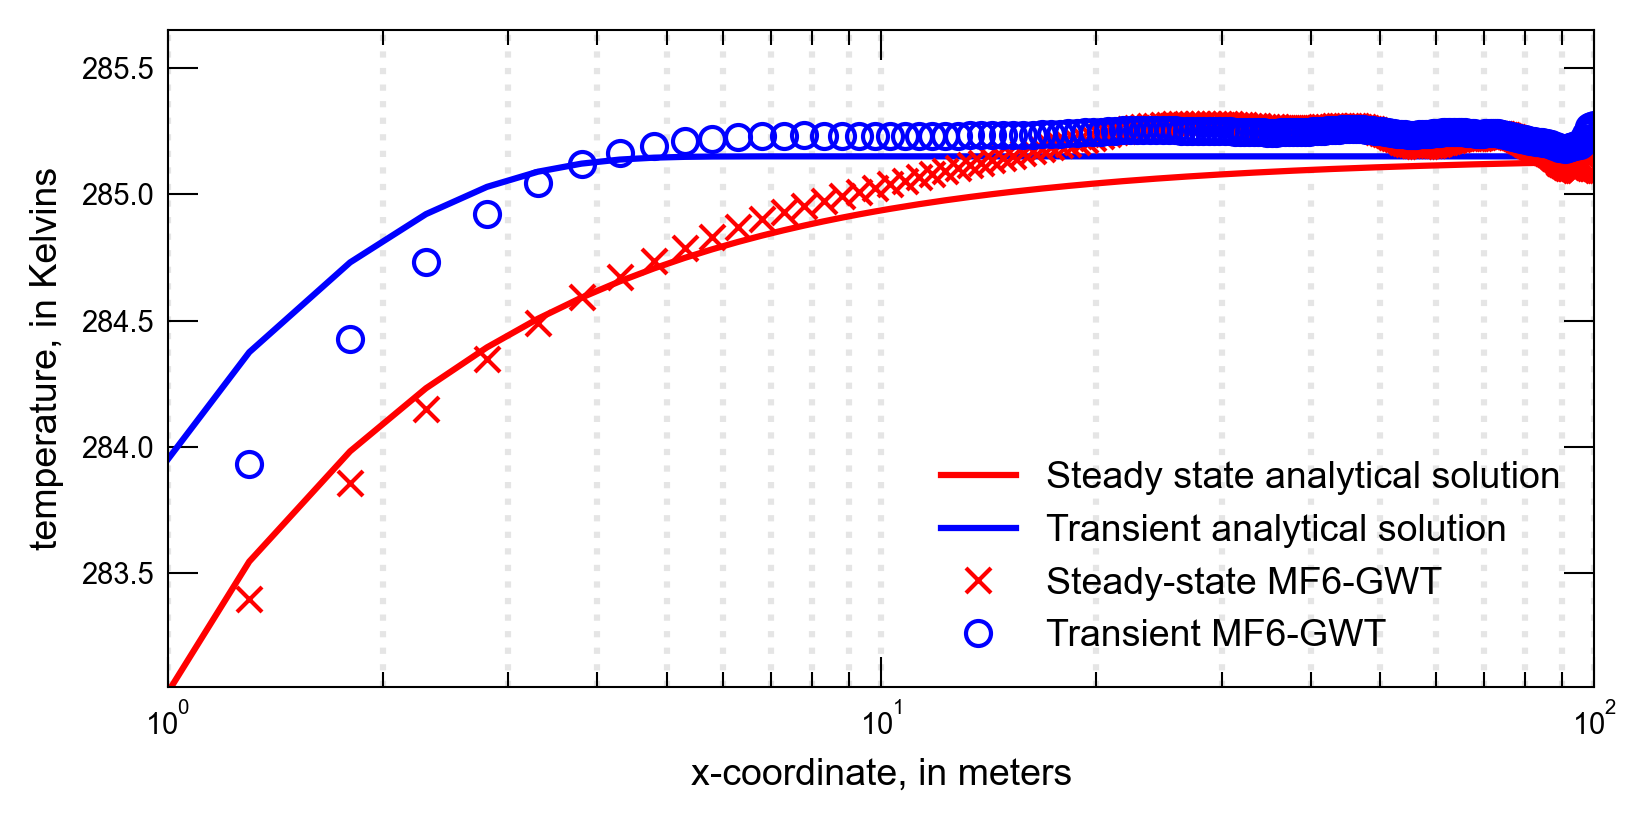

Building mf6gwf model...ex-gwt-hecht-mendez-c
Building mf6gwt model...ex-gwt-hecht-mendez-c
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwf-hecht-mendez...
    writing model name file...
    writing package dis...
    writing package ic...


    writing package npf...
    writing package sto...
    writing package chd-1...
INFORMATION: maxbound in ('gwf6', 'chd', 'dimensions') changed to 2158 based on size of stress_period_data
    writing package oc...
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims_-1...
  writing model gwt-hecht-mendez...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package adv...
    writing package dsp-1...
    writing package mst-1...
    writing package ssm...
    writing package src-1...
    writing package fmi...
    writing package oc...
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compil

    Solving:  Stress period:     1    Time step:     1


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/14 20:11:11
 Elapsed run time:  3.253 Seconds
 
 Normal termination of simulation.
FloPy is using the following executable to run the model: ../../../../../../.local/bin/modflow/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev2 (preliminary) 05/13/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled May 13 2024 02:36:38 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
s

    Solving:  Stress period:     1    Time step:     1


    Solving:  Stress period:     1    Time step:     2


    Solving:  Stress period:     1    Time step:     3


    Solving:  Stress period:     1    Time step:     4


    Solving:  Stress period:     1    Time step:     5


    Solving:  Stress period:     1    Time step:     6


    Solving:  Stress period:     1    Time step:     7


    Solving:  Stress period:     1    Time step:     8


    Solving:  Stress period:     1    Time step:     9


    Solving:  Stress period:     1    Time step:    10


    Solving:  Stress period:     1    Time step:    11


    Solving:  Stress period:     1    Time step:    12


    Solving:  Stress period:     1    Time step:    13


    Solving:  Stress period:     1    Time step:    14


    Solving:  Stress period:     1    Time step:    15


    Solving:  Stress period:     1    Time step:    16


    Solving:  Stress period:     1    Time step:    17


    Solving:  Stress period:     1    Time step:    18


    Solving:  Stress period:     1    Time step:    19


    Solving:  Stress period:     1    Time step:    20


    Solving:  Stress period:     1    Time step:    21


    Solving:  Stress period:     1    Time step:    22


    Solving:  Stress period:     1    Time step:    23


    Solving:  Stress period:     1    Time step:    24


    Solving:  Stress period:     1    Time step:    25


    Solving:  Stress period:     1    Time step:    26


    Solving:  Stress period:     1    Time step:    27


    Solving:  Stress period:     1    Time step:    28


    Solving:  Stress period:     1    Time step:    29


    Solving:  Stress period:     1    Time step:    30


    Solving:  Stress period:     1    Time step:    31


    Solving:  Stress period:     1    Time step:    32


    Solving:  Stress period:     1    Time step:    33


 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/05/14 20:12:13
 Elapsed run time:  1 Minutes,  2.534 Seconds
 
 Normal termination of simulation.
run_models took 65844.56 ms


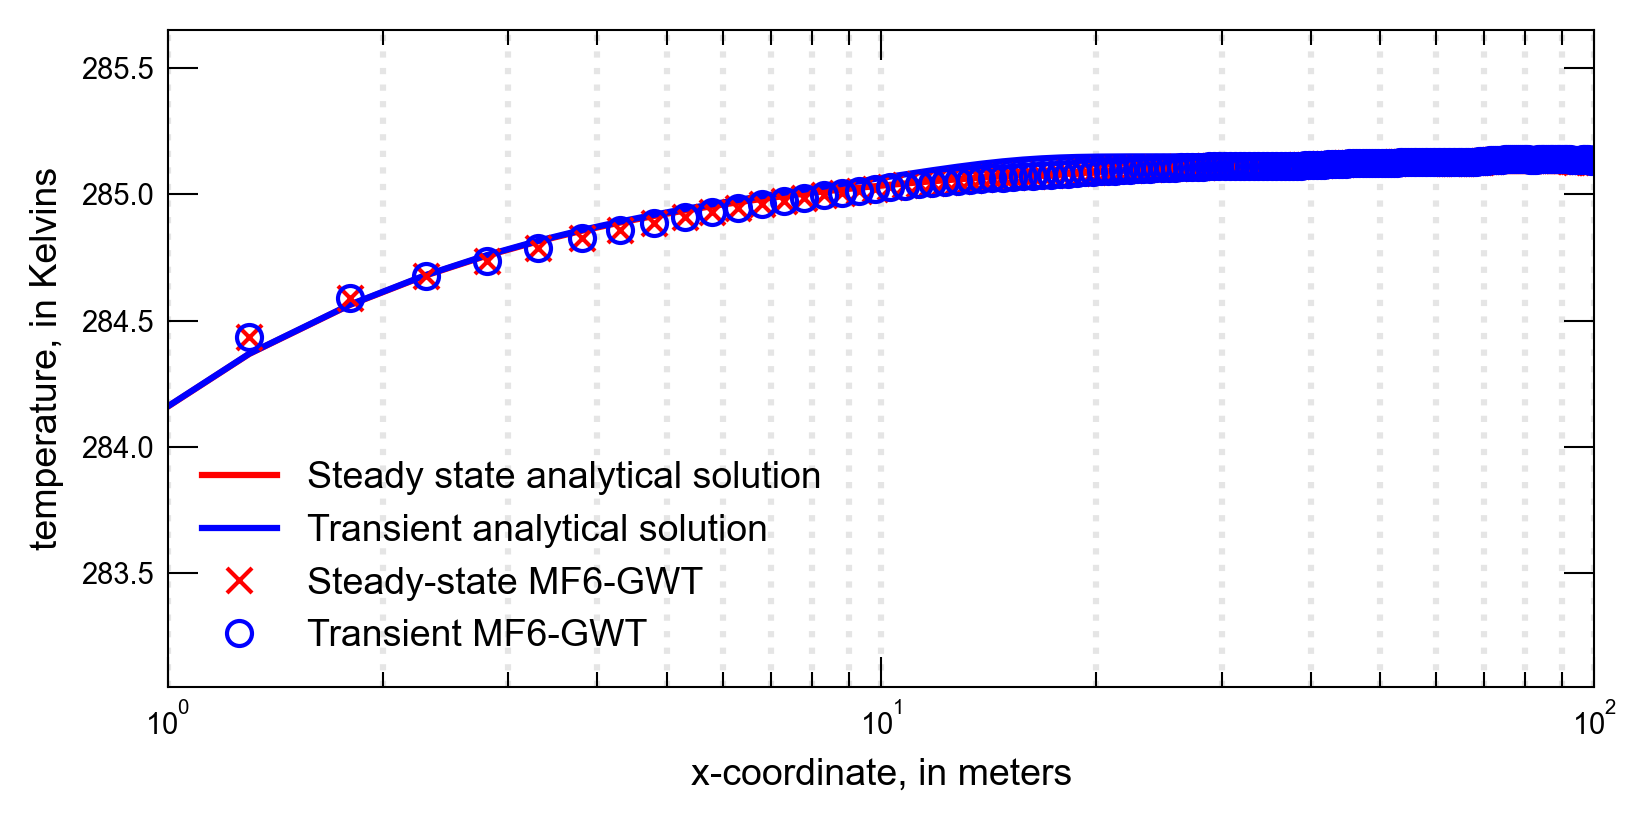

In [5]:
def scenario(idx, runMT3D=False, silent=True):
    key = list(parameters.keys())[idx]
    parameter_dict = parameters[key]
    mf2k5 = build_mf2k5_flow_model(key, **parameter_dict) if runMT3D else None
    mt3d = build_mt3d_transport_model(mf2k5, key, **parameter_dict) if runMT3D else None
    sim_mf6gwf = build_mf6_flow_model(key, **parameter_dict)
    sim_mf6gwt = build_mf6_transport_model(key, **parameter_dict)

    if write:
        if runMT3D:
            write_mf2k5_models(mf2k5, mt3d, silent=silent)
        write_mf6_models(sim_mf6gwf, sim_mf6gwt, silent=silent)
    if run:
        run_models(sim_mf6gwf, sim_mf6gwt, mf2k5=mf2k5, mt3d=mt3d, silent=silent)
    if plot:
        plot_results(
            sim_mf6gwf,
            sim_mf6gwt,
            idx,
            mf2k5=mf2k5,
            mt3d=mt3d,
            **parameter_dict,
        )


# ### Two-Dimensional Transport in a Diagonal Flow Field
#
# Compares the standard finite difference solutions between MT3D MF 6
# when the Peclet number is 0
# Not simulated because no known analytical solution to compare to
# scenario(0, silent=False)

# Compares the standard finite difference solutions between MT3D MF 6
# when the Peclet number is 0
scenario(1, silent=False)

# Compares the standard finite difference solutions between MT3D MF 6
# when the Peclet number is 0
scenario(2, silent=False)